In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- [기상청 ASOS 5분 단위 데이터](https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&tabNo=1)
- [관측지점 메타 정보](https://data.kma.go.kr/tmeta/stn/selectStnList.do)
- [공공데이터 포털: 공휴일](https://www.data.go.kr/data/15012690/openapi.do)
- [한국전력 에너지마켓플레이스 OPEN API: 계약종별 전력사용량 API](https://bigdata.kepco.co.kr/cmsmain.do?scode=S01&pcode=000493&pstate=cntr&redirect=Y)
  - [시도코드표](https://sgis.kostat.go.kr/developer/html/openApi/api/dataCode/SidoCode.html)

# **CNN+Bi-LSTM: Kernel별 성능 비교**
- 목표1 : 7개의 지역 가중 데이터를 활용해서 5분 단위 전력수요 예측하기
- 목표2 : 최적의 Kernel_size 찾기
- 칼럼 : 최저기온, 최고기온, 평균기온, 평균일사, 더미변수(요일, 휴일, 월, 시간)
- 데이터크기 : 338111 rows × 60 columns
- 모델종류 : Kernel_size=3,5,7인 CNN_Bi-LSTM

- 절차
>- 기상 데이터 수집
>- 지점별 선형보간
>- 더미변수 생성
>- 지역별 가중치 구하기
>- 가중평균 칼럼 생성
>- 기상 대표값 도출
>- 모델 학습
>- 모델 비교

|분류|사용변수|
|---|---|
|기준시점(1개)| 각 데이터의 기준 시점, 모델학습 미포함|
|기상인자 (4개) | 최고기온, 최저기온, 가중평균기온, 가중평균일사량|
|달력정보 (54개) | 요일특성(Dummy, 4개), 휴일유형 (Dummy, 14개), 월(Dummy, 12개), 시간(Dummy, 24개)|
|전력수요 (1개)| 5분당 전력수요|

## A. **라이브러리 로드**
- 대용량 파일을 다루기 위해서 `pd.read_parquet`를 사용
- MAPE 계산을 위해 `torchmetrics` 라이브러리를 사용
- 동일 결과를 얻기 위해 `seed=222`로 고정

In [ ]:
# 필요한 라이브러리 설치
!pip install parquet
!pip install torchmetrics -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.4/643.4 kB 36.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 8.0 MB/s eta 0:00:00
  Created wheel for thriftpy2: filename=thriftpy2-0.4.16-cp310-cp310-linux_x86_64.whl size=1180276 sha256=98e99d45eb53c65d345abac4e4ef426655c6fee4ac15e8c00f2f5553438216fb
  Stored in directory: /root/.cache/pip/wheels/95/f5/1d/fe404692e1c8aaea45220c322d1d0f32c9fd40eb0e2bdd571e
Successfully built thriftpy2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 22.9 MB/s eta 0:00:00


In [ ]:
# 라이브러리 로드
import random
import numpy as np
import pandas as pd
import datetime
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

import torch
import torch.nn as nn
from torchmetrics import MeanAbsolutePercentageError
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler

# 랜덤시드 고정

seed = 222
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## B. **데이터 전처리 및 로드**

### B-1. **기상데이터 불러오기**
- 각 시를 기준으로 '서울', '부산', '인천', '대구', '대전', '광주', '원주'를 사용
  - '세종', '울산'의 결측값이 많으므로 제외
  - 강원도 부근의 기상 정보를 포함하기 위해 대표지역으로 인구수가 많은 '원주'를 선택
- 각 지점별로 기온 선형보간
- 가중치 적용 전 최저, 최고 기온 도출
- 가중치 적용 후 가중평균 기온과 일사 도출
- 더미변수 생성(요일, 휴일, 월, 시간)

In [ ]:
def weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path, region_weigths_dict):
  ################################################ 기상 데이터 불러오기 ##############################################
  
  # 기상관측 MetaData 불러오기
  weather_metadata = pd.read_csv(weather_metadata_path)
  STN_dict = {STN_name : STN_num for STN_num, STN_name in zip(weather_metadata['지점'], weather_metadata['지점명'])}
  target_STN_list = [STN_dict[STN_name] for STN_name in ['서울', '부산', '인천', '대구', '대전', '광주', '원주']]

  # 서울 포함 7개 도시의 기온 및 일사량 데이터 불러오기
  weather_5minute = pd.read_parquet(weather_5minute_ASOS_path).astype({'지점' : 'int'})
  weather_5minute = weather_5minute[weather_5minute['지점'].isin(target_STN_list)]
  weather_5minute = weather_5minute[['지점', '일시', '기온(°C)', '일사(MJ/m^2)']]
  weather_5minute.columns = ['지점', '일시', '기온', '일사']

  ################################################ 데이터 선형보간 ###################################################
    
  column_list = ['기온', '일사']

  # 선형보간법 사용하여 결측값 채우기
  for idx, STN in enumerate(target_STN_list):

      # 각 STN별로 데이터 나누기
      tmp = weather_5minute[weather_5minute['지점'] == STN]

      # 시간순으로 정렬하기
      tmp = tmp.sort_values(by='일시')

      # 선형보간법을 사용하여 nan값 채우기                
      for column in column_list:
          tmp[column] = tmp[column].interpolate(method='linear')

      # tmp 합치기
      if idx == 0:
          interpolated_weather = tmp
      else:
          interpolated_weather = pd.concat([interpolated_weather, tmp])
  
  interpolated_weather = interpolated_weather[interpolated_weather['일시']<"2023-03-20"]    # 기간 조정

  ################################################ 가중 평균 ###################################################
  
  df = interpolated_weather.copy()

  # 메타정보로 시도 칼럼 생성
  def get_loc_info(data):
      try:
          return stn_replace_dict[data]
      except:
          return 'No Info'

  weather_metadata["시도"] = weather_metadata["지점주소"].str.split().str[0]
  stn_replace_dict = dict((weather_metadata[['지점', '시도']].values.tolist()))

  df['시도'] = df['지점'].apply(get_loc_info)

  # 가중평균 데이터
  df["Year-Region"] = df["일시"].str[:8] + df["시도"]
  df["Year-Region"] = df["Year-Region"].apply(lambda x: region_weigths_dict[x])
  for col in ['기온', '일사']:
      df[col] *= df["Year-Region"]
  weighted = df.groupby(["일시"], as_index=False)[['기온', '일사']].sum()
  weighted.columns = ['datetime', 'temp', 'insolation']
        
  ################################################ 최고, 최저 기온 ###################################################

  # 최고 기온
  tmp_1 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)['기온'].max()).rename(columns = {'기온' : 'max_temp'})
  # 최저 기온
  tmp_2 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)['기온'].min()).rename(columns = {'기온' : 'min_temp'})
  representative_weather = pd.merge(tmp_1, tmp_2, on = '일시', how = 'inner')
  representative_weather.rename(columns = {'일시' : 'datetime'}, inplace= True)

  ################################################ 더미 변수 ###################################################
  
  # 요일 특성 반영 (더미변수로 반영)
  # 0 : 월요일, 1 : 화요일 ~ 금요일, 2 : 토요일, 3 : 일요일

  representative_weather['weekday'] = pd.to_datetime(representative_weather['datetime']).dt.weekday
  representative_weather.replace({'weekday' : {2 : 1, 3 : 1, 4 : 1, 5 : 2, 6 : 3}}, inplace = True)
  representative_weather = pd.get_dummies(representative_weather, columns = ['weekday'])
                                          
  # 휴일 유형에 맞춘 더미변수 반영

  holiday = pd.read_csv(holiday_path)

  for dateName in ['국회의원선거일', '대통령선거일', '동시지방선거일', '전국동시지방선거', '제21대 국회의원선거']:
      holiday.replace({'dateName' : {dateName : '선거일'}}, inplace = True)
  holiday.replace({'dateName' : {'1월1일' : '신정'}}, inplace = True)
  holiday.replace({'dateName' : {'부처님오신날' : '석가탄신일'}}, inplace = True)
  holiday.replace({'dateName' : {'어린이 날' : '어린이날'}}, inplace = True)
  holiday.replace({'dateName' : {'대체휴무일' : '대체공휴일'}}, inplace = True)
  holiday.replace({'dateName' : {'임시공휴일' : '대체공휴일'}}, inplace = True)

  nameToNumber = {dateName : idx + 1  for idx, dateName in enumerate(list(holiday['dateName'].unique()))}
  holiday.replace({'dateName' : nameToNumber}, inplace = True)
  holiday_dict = {locdate : dateName for dateName, locdate in zip(holiday['dateName'], holiday['locdate'])}

  for row_number in range(representative_weather.shape[0]):
      if representative_weather.at[row_number, 'datetime'][:-6] in list(holiday['locdate']):
          representative_weather.at[row_number, 'holiday'] = holiday_dict[representative_weather.at[row_number, 'datetime'][:-6]]
      else:
          representative_weather.at[row_number, 'holiday'] = 0

  representative_weather = pd.get_dummies(representative_weather, columns = ['holiday'])

  # 월, 시간 정보 반영 (더미변수로 반영)

  representative_weather['month'] = pd.to_datetime(representative_weather['datetime']).dt.month
  representative_weather = pd.get_dummies(representative_weather, columns = ['month'])
  representative_weather['hour'] = pd.to_datetime(representative_weather['datetime']).dt.hour
  representative_weather = pd.get_dummies(representative_weather, columns = ['hour'])

  return pd.merge(weighted, representative_weather, on='datetime', how='inner')

### B-2. **지역 가중치 구하기**
- [한전API](https://bigdata.kepco.co.kr/cmsmain.do?scode=S01&pcode=000493&pstate=cntr&redirect=Y)로부터 각 지역별로 월별 전력 가중치를 도출
  - '원주'는 강원도 데이터를 사용

In [ ]:
# API에서 지역정보 가져오기
def get_region_weights(load=False, api_key=None, start_date=str, end_date=str, save_path=None):
  '''
  start_date = "Year-Month", ex. "2020-01"
  end_date = "Year-Month", ex. "2023-03"
  '''
  ################################################ API 데이터 수집 ###################################################
  if not load:    # 파일을 읽어오지 않는다면 API로부터 데이터 수집
      # 시도 코드
      metro_code_list = [11, 21, 22, 23, 24, 25, 32]  # 원주 대신 강원도 사용
      
      # 날짜별로 데이터 수집
      start_date = datetime.datetime.strptime(start_date, '%Y-%m')
      end_date = datetime.datetime.strptime(end_date, '%Y-%m') + relativedelta(months=1)
      tmp_list = []
      for _ in tqdm(pd.date_range(start_date, end_date, freq="m")):
          
          # 연/월 분리
          year = str(start_date.year)
          month = "{:>02}".format(str(start_date.month))
          
          # Open API로 부터 데이터 로드
          for i in metro_code_list:
              url = f'https://bigdata.kepco.co.kr/openapi/v1/powerUsage/houseAve.do?year={year}&month={month}&metroCd={i}&cityCd=&apiKey={api_key}&returnType=json'

              response = requests.get(url)
              json = response.json()
              
              # 데이터 수집 시도
              try:
                  for dic in json['data']:
                      tmp_list.append(dic)    # 데이터가 있다면 저장
              except:
                  continue    # 데이터가 없다면 작업없음
              
          start_date += relativedelta(months=1) # 월 정보 증가

      # API 데이터에서 연-월 정보 수집
      power_demand_house_metro = pd.DataFrame(tmp_list)
      power_demand_region_df = pd.DataFrame(tmp_list).groupby(["year", "month", "metro"], as_index=False)[["powerUsage"]].sum()
      
      # 저장
      if save_path is not None:
          power_demand_region_df.to_pickle(save_path)

  else:   # 경로에 파일이 있다면 읽어옵니다
      power_demand_region_df = pd.read_pickle(save_path)
  
  ################################################ 딕셔너리 생성 ###################################################
  
  # 연-월별로 비율 계산
  power_demand_region_df['y-m'] = power_demand_region_df['year'] + '-' + power_demand_region_df['month']
  y_m_sum = power_demand_region_df.groupby(["y-m"], as_index=False)["powerUsage"].sum()   # 연-월 전력 총 사용량 계산
  y_m_sum_dict = dict(y_m_sum.values.tolist())                                            # 연-월 전력 총 사용량 딕셔너리
  power_demand_region_df['y-m'] = power_demand_region_df['y-m'].apply(lambda x: y_m_sum_dict[x])  # 전력 총 사용량 칼럼에 반영
  power_demand_region_df["powerUsage"] /= power_demand_region_df["y-m"]                   # 전력 총 사용량으로 나눠서 비율 구하기
  power_demand_region_df["date_region"] = power_demand_region_df['year'] + '-' + power_demand_region_df['month'] + '-' + power_demand_region_df["metro"]  # 연-월-시도 딕셔너리 키 준비
  region_weigths_dict = dict(power_demand_region_df[["date_region", "powerUsage"]].values.tolist())   # 연-월-시도 딕셔너리 생성
  
  return region_weigths_dict

### B-3. **기상대표값 데이터 생성**
- 지역 가중치 적용된 기상 데이터 가져오기
- 전력(라벨) 데이터 추가하기

In [ ]:
############################################ 지역 가중치 얻기 ####################################################################

api_key = '85Go6o3gCfJTsZ3226WAW0NnO36gh9Nb8Kd1QZpp'  # 개인 API_KEY

start_date = "2020-01"
end_date = "2023-03"
save_path = f"/content/drive/MyDrive/DL Project/data/processed/region_weights_{start_date}_{end_date}_v2.pickle"

# 서울, 부산, 대구, 인천, 광주, 대전, 원주(강원도)
# load=False면 API로부터 데이터를 가져옵니다
# load=True면 경로로부터 가중치 파일을 읽어옵니다
region_weigths_dict = get_region_weights(load=True, api_key=api_key, start_date=start_date, end_date=end_date, save_path=save_path)

############################################ 기상대표값 데이터 생성하기 ############################################################

weather_metadata_path = '/content/drive/MyDrive/DL Project/data/processed/weather_localcenter_metadata.csv'
weather_5minute_ASOS_path = '/content/drive/MyDrive/DL Project/data/processed/weather_5minute_ASOS_2020-2023.parquet'
holiday_path = '/content/drive/MyDrive/DL Project/data/processed/holidays.csv'

representative_weather = weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path, region_weigths_dict)

############################################ 전력 데이터 불러오기 ################################################################

power_path = '/content/drive/MyDrive/DL Project/data/processed/power_demand_interpolated.csv'

power = pd.read_csv(power_path)
power.columns = ['datetime', 'load']

###################################### 전력 데이터와 기상인자 데이터 합치기 #######################################################

target_df = pd.merge(representative_weather, power, on = 'datetime', how = 'inner')
target_df

,datetime,temp,insolation,max_temp,min_temp,weekday_0,weekday_1,weekday_2,weekday_3,holiday_0.0,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,load
0,2020-01-01 00:05,-5.430015,0.000000,-2.5,-7.6,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,65295.7
1,2020-01-01 00:10,-5.442777,0.000000,-2.6,-7.6,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,65098.7
2,2020-01-01 00:15,-5.458356,0.000601,-2.5,-7.6,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,64927.2
3,2020-01-01 00:20,-5.447638,0.000601,-2.6,-7.6,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,64480.8
4,2020-01-01 00:25,-5.419021,0.001201,-2.6,-7.7,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,64438.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338106,2023-03-19 23:35,6.790464,21.504471,10.4,1.9,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,58627.2
338107,2023-03-19 23:40,6.746992,21.505070,10.4,1.9,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,57941.2
338108,2023-03-19 23:45,6.692631,21.505070,10.4,1.8,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,57726.2
338109,2023-03-19 23:50,6.631788,21.505670,10.4,1.8,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,57755.4


## C. **모델 - 1D CNN + 양방향 LSTM**
* LSTM Layer의 개수 : 2개 (양방향 LSTM Layer)
* Input Dimension(사용한 컬럼의 개수) : 59개
* output Dimension(1회 출력갯수) : 72개
* 총 출력갯수 : 2016(23년 3월 13일 ~ 3월 19일 5분 단위 데이터)

* 학습시간 : 약 4시간 41분 (53분, 175분, 53분)
* Train, Test 데이터를 미리 분리한 후, Train 데이터셋에만 Scaler를 Fit-Transform하여 학습하고 테스트 시에 Scaler로 Transform만 진행하여 Test 진행
* **TEST_MAPE**
  * **Kernel size 3 : 3.764%**
  * **Kernel size 5 : 2.873%**
  * **Kernel size 7 : 3.611%**

### C-1. **커스텀 데이터셋**
- 메모리 문제를 완화하기 위해 커스텀 데이터셋 구축
- 훈련용 데이터셋: fit_transform 적용
- 평가용 데이터셋: transform 적용
- Scaler : MinMaxScaler
- seq_len = 2016
- step_len = 72
- stride = 1
- 테스트 데이터셋 기간:  23년 3월 6일 ~ 3월 19일
- 훈련 데이터셋 기간: 20년 1월 1일 ~ 23년 3월 13일

In [ ]:
###################################### 학습용 커스텀 데이터 셋 #######################################################
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    # 훈련 데이터셋에서 스케일러 학습
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.fit_transform(target_df.iloc[:,1:binary_var_start_number]))  # 특성 데이터 스케일러 적용
                                                               target_df.iloc[:,binary_var_start_number:-1],                                          # 더미변수 스케일러 미적용
                                                               pd.DataFrame(scaler_for_Y.fit_transform(np.array(target_df['power']).reshape(-1, 1)))], axis = 1))).cuda() # 라벨 데이터 스케일러 적용          
    self.data_size = (self.dataset_tensor.shape[0] - step_len - seq_len) // stride + 1
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride = stride
  
  def __len__(self):  # 데이터 크기
    return self.data_size
  
  def __getitem__(self, idx): # 반환할 데이터
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]
    
###################################### 평가용 커스텀 데이터 셋 정의 #######################################################
class CustomDatasetForTest(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    # 평가 데이터셋에서 스케일러 단순 변환
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1].reset_index(drop = True),
                                                               pd.DataFrame(scaler_for_Y.transform(np.array(target_df['power']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = (self.dataset_tensor.shape[0] - step_len - seq_len) // stride + 1
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride = stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

# Scaler 객체 생성
ss_1 = MinMaxScaler() # Scaler for X
ss_2 = MinMaxScaler() # Scaler for y

# CustomDataset 파라미터 설정 (Scaler 객체, 시퀀스의 길이, 스텝 사이즈, 건너뛸 간격)
seq_len = 2016  # 시퀀스의 길이
step_len = 72   # 스텝 사이즈 (추정하고자 하는 값의 개수)
stride = 1      # 건너뛸 간격

# target_df를 train_df와 test_df로 분리
test_df = target_df.iloc[-1 * (seq_len + seq_len):,:]
train_df = target_df.iloc[:-1 * (seq_len),:]

# 데이터셋 생성
train_dataset = CustomDataset(train_df, 4, ss_1, ss_2, seq_len, step_len, stride)
test_dataset = CustomDatasetForTest(test_df, 4, ss_1, ss_2, seq_len, step_len, 72)

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle = False, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, drop_last = True)

### C-2. **CNN+Bi-LSTM 구성**
* 합성곱 커널 사이즈 : 3, 5, 7
* 합성곱 필터의 개수 : 118
* Hidden State의 개수 : 288개
* Sequence의 길이 : 2016개 (1일당 5분 간격 데이터 288개 * 일주일)

In [ ]:
# CNN + 양방향 LSTM 모델 구성하기
###################################### 모델 인자 #######################################################
in_channels = train_df.shape[1] - 1 # 입력 컬럼의 개수
out_channels = in_channels * 2 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 30 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

###################################### 모델 구성 #######################################################
class CNN_BILSTM(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):
    super(CNN_BILSTM, self).__init__()
    # 입력인자 정의
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    # 합성곱 Layer 정의
    self.conv1d = nn.Conv1d(in_channels = self.in_channels, 
                            out_channels = self.out_channels,
                            kernel_size = self.kernel_size, 
                            padding = 'same')
    # LSTM Layer 정의
    self.lstm = nn.LSTM(self.out_channels, 
                        self.hidden_dim, 
                        num_layers = self.layers, 
                        batch_first = True, 
                        bidirectional = True)
    # 완전연결층 정의
    self.fc = nn.Linear(hidden_dim * 2, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
  
  # 결과값 계산
  def forward(self, x):
    x = torch.transpose(x, 1, 2)
    x = self.conv1d(x)
    x = torch.transpose(x, 1, 2)
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

### C-3. **모델 학습**
- loss : MAPE
- optimizer = Adam
- Kernel_size= 3, 5, 7

In [ ]:
# 모델 학습 함수 만들기

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from torchmetrics import MeanAbsolutePercentageError
from tqdm import tqdm

###################################### 모델 학습 구성 #######################################################
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  nb_epochs = num_epochs
  mean_abs_percentage_error = MeanAbsolutePercentageError().to(device)

  # epoch마다 loss 저장
  train_hist = np.zeros(nb_epochs)
  output = []
  
  for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(train_df)
    for samples in tqdm(train_df):
      x_train, y_train = samples

      # seq별 hidden state reset
      model.reset_hidden_state()

      # H(x) 계산
      outputs = model(x_train)

      # cost 계산
      loss = mean_abs_percentage_error(outputs, y_train)

      # cost로 H(x) 개선
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_cost += loss/total_batch 

    train_hist[epoch] = avg_cost  # epoch마다 loss 대입

    if epoch % verbose == 0:
      print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print('\n Early Stopping')
        break
  
  return model.eval(), train_hist

In [ ]:
# 모델 저장 날짜
import datetime
now = datetime.datetime.today()
today = str(now.year) + str(now.month) + str(now.day)
today

'2023531'

#### C-3-a. **Kernel_size=3**

In [ ]:
# CNN + 양방향 LSTM 모델 학습 (Bidirectional LSTM layer=2)

# kernel_size = 3 모델
kernel_size = 3 # 합성곱 필터의 kernel_size

cnn_bilstm = CNN_BILSTM(in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers = 2).to(device)
cnn_bilstm_model_kernel_3, cnn_bilstm_hist_3 = train_model(cnn_bilstm, train_dataloader, num_epochs = nb_epochs,
                                                         lr = learning_rate, verbose = 1, patience = 4)
# 모델 저장
kernel3_save_path = f'/content/drive/MyDrive/Model_pth/model_{today}_CNN-BILSTM_kernel3.pth'
torch.save(cnn_bilstm_model_kernel_3, kernel3_save_path)

100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0000 train loss : 1.1640


100%|██████████| 1304/1304 [05:48<00:00,  3.74it/s]


Epoch: 0001 train loss : 1.0267


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0002 train loss : 1.0153


100%|██████████| 1304/1304 [05:48<00:00,  3.74it/s]


Epoch: 0003 train loss : 0.8789


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0004 train loss : 0.3977


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0005 train loss : 0.8322


100%|██████████| 1304/1304 [05:48<00:00,  3.74it/s]


Epoch: 0006 train loss : 0.2982


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0007 train loss : 0.7032


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]

Epoch: 0008 train loss : 0.4104

 Early Stopping


#### C-3-a. **Kernel_size=5**

In [ ]:
# kernel_size = 5 모델
kernel_size = 5 # 합성곱 필터의 kernel_size

cnn_bilstm = CNN_BILSTM(in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers = 2).to(device)
cnn_bilstm_model_kernel_5, cnn_bilstm_hist_5 = train_model(cnn_bilstm, train_dataloader, num_epochs = nb_epochs,
                                                         lr = learning_rate, verbose = 1, patience = 4)
# 모델 저장
kernel5_save_path = f'/content/drive/MyDrive/Model_pth/model_{today}_CNN-BILSTM_kernel5.pth'
torch.save(cnn_bilstm_model_kernel_5, kernel5_save_path)

100%|██████████| 1304/1304 [05:48<00:00,  3.74it/s]


Epoch: 0000 train loss : 1.1247


100%|██████████| 1304/1304 [05:48<00:00,  3.74it/s]


Epoch: 0001 train loss : 0.9768


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0002 train loss : 0.4069


100%|██████████| 1304/1304 [05:48<00:00,  3.74it/s]


Epoch: 0003 train loss : 0.7012


100%|██████████| 1304/1304 [05:49<00:00,  3.74it/s]


Epoch: 0004 train loss : 0.3077


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0005 train loss : 0.4209


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0006 train loss : 0.2847


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0007 train loss : 0.2483


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0008 train loss : 0.2014


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0009 train loss : 0.1981


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0010 train loss : 0.5548


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0011 train loss : 0.1609


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0012 train loss : 0.1902


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0013 train loss : 0.1463


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0014 train loss : 0.1496


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0015 train loss : 0.1658


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0016 train loss : 0.1712


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0017 train loss : 0.2027


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0018 train loss : 0.1442


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0019 train loss : 0.1601


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0020 train loss : 0.1281


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0021 train loss : 0.1354


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0022 train loss : 0.1225


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0023 train loss : 0.1311


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0024 train loss : 0.1208


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0025 train loss : 0.2458


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0026 train loss : 0.1250


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0027 train loss : 0.1288


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0028 train loss : 0.1035


100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]

Epoch: 0029 train loss : 0.1068


#### C-3-a. **Kernel_size=7**

In [ ]:
# kernel_size = 7 모델
kernel_size = 7 # 합성곱 필터의 kernel_size

cnn_bilstm = CNN_BILSTM(in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers = 2).to(device)
cnn_bilstm_model_kernel_7, cnn_bilstm_hist_7 = train_model(cnn_bilstm, train_dataloader, num_epochs = nb_epochs,
                                                         lr = learning_rate, verbose = 1, patience = 4)
# 모델 저장
kernel7_save_path = f'/content/drive/MyDrive/Model_pth/model_{today}_CNN-BILSTM_kernel7.pth'
torch.save(cnn_bilstm_model_kernel_7, kernel7_save_path)

100%|██████████| 1304/1304 [05:49<00:00,  3.73it/s]


Epoch: 0000 train loss : 1.0631


100%|██████████| 1304/1304 [05:50<00:00,  3.73it/s]


Epoch: 0001 train loss : 0.9263


100%|██████████| 1304/1304 [05:50<00:00,  3.72it/s]


Epoch: 0002 train loss : 0.2976


100%|██████████| 1304/1304 [05:50<00:00,  3.72it/s]


Epoch: 0003 train loss : 0.4518


100%|██████████| 1304/1304 [05:50<00:00,  3.72it/s]


Epoch: 0004 train loss : 0.2447


100%|██████████| 1304/1304 [05:50<00:00,  3.72it/s]


Epoch: 0005 train loss : 0.9635


100%|██████████| 1304/1304 [05:50<00:00,  3.72it/s]


Epoch: 0006 train loss : 0.2238


100%|██████████| 1304/1304 [05:50<00:00,  3.72it/s]


Epoch: 0007 train loss : 0.4286


100%|██████████| 1304/1304 [05:50<00:00,  3.72it/s]

Epoch: 0008 train loss : 0.2837

 Early Stopping


### C-4. **모델별 학습 과정**
- Kernel_size=3,7은 Epoch=7,8에서 Early Stopping 됨
- Kernel_size=5는 최대횟수 Epoch 30회로 정지됨
- Kernel_size=5는 성능이 더 좋아질 가능성이 있음

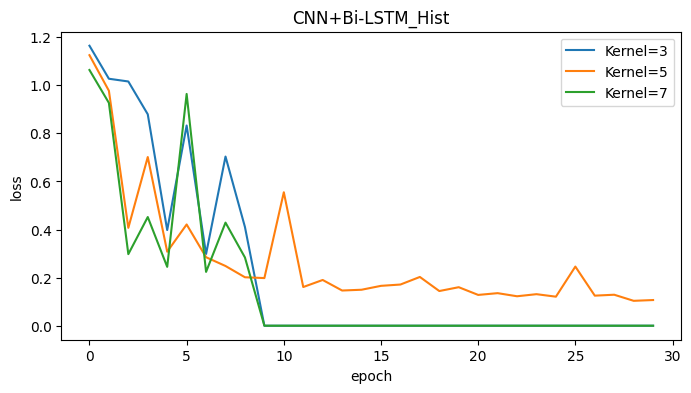

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(cnn_bilstm_hist_3, label='Kernel=3')
sns.lineplot(cnn_bilstm_hist_5, label='Kernel=5')
sns.lineplot(cnn_bilstm_hist_7, label='Kernel=7')
plt.title('CNN+Bi-LSTM_Hist')
plt.xlabel('epoch')
plt.ylabel("loss")
plt.legend()
plt.show()

### C-5. **모델 평가**
- Kernel_size = 3의 MAPE: 3.764%
- Kernel_size = 5의 MAPE: 2.873%
- Kernel_size = 7의 MAPE: 3.611%
- **Kernel_size=5가 다른 모델보다 변곡점 부근에서 뛰어난 예측을 보임**

In [ ]:
###################################### 모델 불러오기 #######################################################
# 모델 불러오기
kernel3_save_path = f'/content/drive/MyDrive/Model_pth/model_2023531_CNN-BILSTM_kernel3.pth'
kernel5_save_path = f'/content/drive/MyDrive/Model_pth/model_2023531_CNN-BILSTM_kernel5.pth'
kernel7_save_path = f'/content/drive/MyDrive/Model_pth/model_2023531_CNN-BILSTM_kernel7.pth'
cnn_bilstm_model_kernel_3 = torch.load(kernel3_save_path)
cnn_bilstm_model_kernel_3.eval()
cnn_bilstm_model_kernel_5 = torch.load(kernel5_save_path)
cnn_bilstm_model_kernel_5.eval()
cnn_bilstm_model_kernel_7 = torch.load(kernel7_save_path)
cnn_bilstm_model_kernel_7.eval()

###################################### 모델 평가하기 #######################################################
with torch.no_grad():

  # 예측값과 실제값을 담을 빈 리스트 준비하기

  cnnbi_pred_list_kernel_3 = []
  cnnbi_pred_list_kernel_5 = []
  cnnbi_pred_list_kernel_7 = []
  cnnbi_true_list = []

  for X, y in test_dataloader:

    # 데이터 로더에서 테스트 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)

    # 모델별 예측값 계산
    pred_kernel_3 = cnn_bilstm_model_kernel_3(X)
    pred_kernel_5 = cnn_bilstm_model_kernel_5(X)
    pred_kernel_7 = cnn_bilstm_model_kernel_7(X)

    # 모델별 예측값 및 실제값을 리스트에 넣어주기
    cnnbi_pred_list_kernel_3.append(ss_2.inverse_transform(pred_kernel_3.cpu().detach().numpy()))
    cnnbi_pred_list_kernel_5.append(ss_2.inverse_transform(pred_kernel_5.cpu().detach().numpy()))
    cnnbi_pred_list_kernel_7.append(ss_2.inverse_transform(pred_kernel_7.cpu().detach().numpy()))
    cnnbi_true_list.append(ss_2.inverse_transform(y.cpu().detach().numpy()))

# 위에서 완성된 예측값, 실제값 리스트로 평균 MAPE 계산하기
cnnbi_MAPE_list_kernel_3 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnnbi_pred_list_kernel_3, cnnbi_true_list)]
cnnbi_MAPE_list_kernel_5 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnnbi_pred_list_kernel_5, cnnbi_true_list)]
cnnbi_MAPE_list_kernel_7 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnnbi_pred_list_kernel_7, cnnbi_true_list)]

# 모델별 평균 MAPE 출력하기
print('커널 사이즈가 3인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 {}% 입니다'.format(round(sum(cnnbi_MAPE_list_kernel_3)/len(cnnbi_MAPE_list_kernel_3) * 100, 3)))
print('커널 사이즈가 5인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 {}% 입니다'.format(round(sum(cnnbi_MAPE_list_kernel_5)/len(cnnbi_MAPE_list_kernel_5) * 100, 3)))
print('커널 사이즈가 7인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 {}% 입니다'.format(round(sum(cnnbi_MAPE_list_kernel_7)/len(cnnbi_MAPE_list_kernel_7) * 100, 3)))

커널 사이즈가 3인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 3.764% 입니다
커널 사이즈가 5인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 2.873% 입니다
커널 사이즈가 7인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 3.611% 입니다


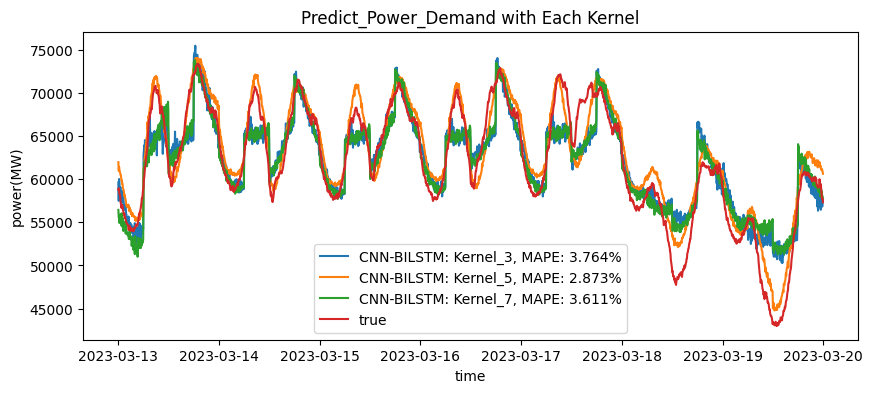

In [ ]:
###################################### 예측값 비교하기 #######################################################
# 데이터 평탄화 작업
pred_flatten_3 = np.array(cnnbi_pred_list_kernel_3).flatten()
pred_flatten_5 = np.array(cnnbi_pred_list_kernel_5).flatten()
pred_flatten_7 = np.array(cnnbi_pred_list_kernel_7).flatten()
true_flatten = np.array(test_df['power'].iloc[2016:]).flatten()

# 데이터프레임화
pred_test_df = pd.DataFrame({
    "time" : test_df['datetime'].iloc[2016:], # 테스트 기간 설정
    'pred_kernel_3' : pred_flatten_3,
    'pred_kernel_5' : pred_flatten_5,
    'pred_kernel_7' : pred_flatten_7,
    'true' : true_flatten
})
pred_test_df['time'] = pred_test_df['time'].astype('datetime64[ms]')

# MAPE 구하기
mape_3 = round(sum(cnnbi_MAPE_list_kernel_3)/len(cnnbi_MAPE_list_kernel_3) * 100, 3)
mape_5 = round(sum(cnnbi_MAPE_list_kernel_5)/len(cnnbi_MAPE_list_kernel_5) * 100, 3)
mape_7 = round(sum(cnnbi_MAPE_list_kernel_7)/len(cnnbi_MAPE_list_kernel_7) * 100, 3)
label_3 = f'CNN-BILSTM: Kernel_3, MAPE: {mape_3}%'
label_5 = f'CNN-BILSTM: Kernel_5, MAPE: {mape_5}%'
label_7 = f'CNN-BILSTM: Kernel_7, MAPE: {mape_7}%'

# 시각화
plt.figure(figsize=(10,4))
sns.lineplot(data=pred_test_df, x='time', y='pred_kernel_3', label=label_3)
sns.lineplot(data=pred_test_df, x='time', y='pred_kernel_5', label=label_5)
sns.lineplot(data=pred_test_df, x='time', y='pred_kernel_7', label=label_7)
sns.lineplot(data=pred_test_df, x='time', y='true', label='true')
plt.title(f"Predict_Power_Demand with Each Kernel")
plt.xlabel("time")
plt.ylabel("power(MW)")
plt.show()

## D. **결론**
- 해당 데이터셋에서 가장 적합한 Kernel_size는 `5` 입니다.
- Kernel_size=5인 모델은 다른 모델과 다르게 Early stopping 하지 않고 최대 epoch 30회를 모두 수행했습니다.
- 따라서 Kernel_size=5인 모델은 추가적인 성능 발전 가능성이 있습니다.
  - Kernel_size=3인 Model은 Epoch=8에서 `Train_MAPE=41.04%`, `Test_MAPE=3.764%`입니다.
  - Kernel_size=5인 Model은 Epoch=29에서 `Train_MAPE=10.68%`, `Test_MAPE=2.873%`입니다.
  - Kernel_size=7인 Model은 Epoch=8에서 `Train_MAPE=28.37%`, `Test_MAPE=3.611%`입니다.
  - Train_MAPE가 낮을수록 Test_MAPE도 낮았습니다.

- 모든 모델은 일반적인 구간에서 좋은 성능을 보입니다만, 변곡점에서 안 좋은 성능을 보여줍니다
- Kernel_size=5 모델은 변곡점에서 다른 모델에 비해 상대적으로 예측이 뛰어납니다.
- 앞으로의 진행하는 모든 CNN모델에 Kernel_size=5을 적용하고, epoch를 50회로 설정합니다